# Introduction

This notebook provides examples of some machine learning methods used in supervised learning. Please refer to the table below to navigate through the notebook.

## Table of Content
0. [Supervised Learning](#supervised)
1. [Libraries](#libraries)
2. [Dataset](#dataset)
1. [KNN](#knn)
2. [SVM](#svm)
3. [Decision Trees](#decision-trees)
4. [Random Forest](#random-forest)

# 0. Supervised Learning <a name="supervised"></a>

Supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs [1]. It infers a function from labelled training data consisting of a set of training examples [2].

![ML](ml2.png)
![ML](ml1.png)

Sources:
- [Wikipedia](https://en.wikipedia.org/wiki/Supervised_learning#:~:text=Supervised%20learning%20is%20the%20machine,a%20set%20of%20training%20examples.)
-  1. Stuart J. Russell, Peter Norvig (2010) Artificial Intelligence: A Modern Approach, Third Edition, Prentice Hall ISBN 9780136042594.
-  2. Mehryar Mohri, Afshin Rostamizadeh, Ameet Talwalkar (2012) Foundations of Machine Learning, The MIT Press ISBN 9780262018258.

## 1. Importing libraries <a name="libraries"></a>

In [1]:
import sklearn
#Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
#Classifiers
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Data visualisation
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
# Hide all warnings
import warnings
warnings.filterwarnings('ignore') # warnings.filterwarnings(action='once')

## 2. About the Geolink Dataset <a name="dataset"></a>

This is a well dataset of Well's Petroleum wells drilled on the Norwegian continental shelf. It was released by the Norweigen Government, cleaned by Geolink, and loaded by LukasMosser. The full dataset has 221 wells, over 150 lithologies, with around 500 MB of data.


You don't need to understand the data fully for this course, but here's a brief overview

- Well - The well name
- DEPT - Depth below the ground in meters
- LITHOLOGY_GEOLINK - This is the facies or lithology, which means rock type. This is a label, made by multiple human experts by looking at the context, the well, maps of the area, and often picture of rock samples extracted from the well.
- [Well logs](https://en.wikipedia.org/wiki/Well_logging): These are specialised measurements by instruments lowered down the well hole
    - CALI - [Caliper log](https://en.wikipedia.org/wiki/Caliper_log), this measures the size of the well bore
    - GR - [Gamma Ray](https://en.wikipedia.org/wiki/Gamma_ray_logging): Measure passive amount of high energy electromagnetic radiation naturally emitted from the rock
    - RHOB - [Bulk Density](https://en.wikipedia.org/wiki/Density_logging): Measured active amount high energy electromagnetic radiation. This has a transmitting source of gamma rays
    - DTC - [Compressional wave](https://en.wikipedia.org/wiki/Longitudinal_wave) travel time: This measure the how long a compressional wave takes to travel through the formationation
    - RDEP - [Resistivity](https://en.wikipedia.org/wiki/Resistivity_logging) Deep: Electrical resistivity through the rock with a deep penetration
    - RMED - Resistivity Medium: Electrical resistivity through the rock with a nedium penetration
    - *Many other well logs were removed as they were not present in all wells*
    
Interpreting lithology from well logs is a very hard problem for machine learning because:

- It's usually done by expert humans (Petrophysicists) with years to decades of experience, not an random human
- it takes into account context in the form of prior knowledge, geology, nearby wells, rock samples, and many more. Many of these are forms of information the machine doesn't have access to
- The data is unbalanced with important rocks like sandstone sometimes appearing as very thin layers


<table>
    <tr>
        <td>
<img width="480" src="../../reports/figures/30-4_1.png"/>
        </td>
        <td>
<img width="320" src="../../data/processed/geolink_norge_dataset/location of geolink wells.png"/>
        </td>
    </tr>
</table>


### Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use this data please reference the dataset properly to give them credit for their contribution.

**Note:** download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

### Data Preparation

The geolink dataset we will use in this notebook has been preprocessed. You can find the process of preparation of this dataset in [Data Preparation](../z00_Data_prep/00-mc-prep_geolink_norge_dataset.ipynb)

## Load Dataset

In [2]:
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
# Load processed dataset
geolink_all = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
# Add Depth as column
geolink_all['DEPT'] = geolink_all.index.get_level_values(1)

# Work with one well
geolink = geolink_all.xs("30_6-11")
geolink

,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,DEPT
DEPT,,,,,,,,,,,,
2085.750000,Cinerite,17.159000,0.072,0.00000,2.220757,109.011002,127.011429,1.170,42.013000,0.547,0.547,2085.750000
2085.875000,Silt,17.187000,0.014,0.00000,2.163988,113.018997,127.219872,1.147,41.969002,0.549,0.549,2085.875000
2086.000000,Silt,17.198000,0.000,0.00000,2.132627,115.380997,127.867149,1.131,42.324001,0.550,0.550,2086.000000
2086.125000,Silt,17.193001,0.032,0.00000,2.138454,116.207001,128.846787,1.125,42.834999,0.545,0.545,2086.125000
2086.250000,Silt,17.179001,0.074,0.00000,2.170922,116.153000,130.015976,1.130,43.605999,0.535,0.535,2086.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
3974.250732,Silt,9.486000,0.044,0.11920,2.486290,54.765999,64.817436,3.815,38.742001,5.172,5.172,3974.250732
3974.375488,Silt,9.487000,0.035,0.11586,2.472456,52.576000,63.746723,3.773,39.074001,5.172,5.172,3974.375488
3974.500488,Silt,9.491000,0.025,0.11379,2.455452,49.529999,63.055447,3.729,38.865002,5.157,5.157,3974.500488


In [3]:
# We're going to use the pandas categorical type for our lithologies
geolink['LITHOLOGY_GEOLINK'].astype('category')

DEPT
2085.750000    Cinerite
2085.875000        Silt
2086.000000        Silt
2086.125000        Silt
2086.250000        Silt
                 ...   
3974.250732        Silt
3974.375488        Silt
3974.500488        Silt
3974.625488        Silt
3974.750488        Silt
Name: LITHOLOGY_GEOLINK, Length: 15113, dtype: category
Categories (26, object): [Anhydrite, Argillaceous Limestone, Calcareous Cement, Carnallite, ..., Silt, Silty Sand, Silty Shale, Volcanic Tuff]

(<Figure size 576x864 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb9adbff98>,
       dtype=object))

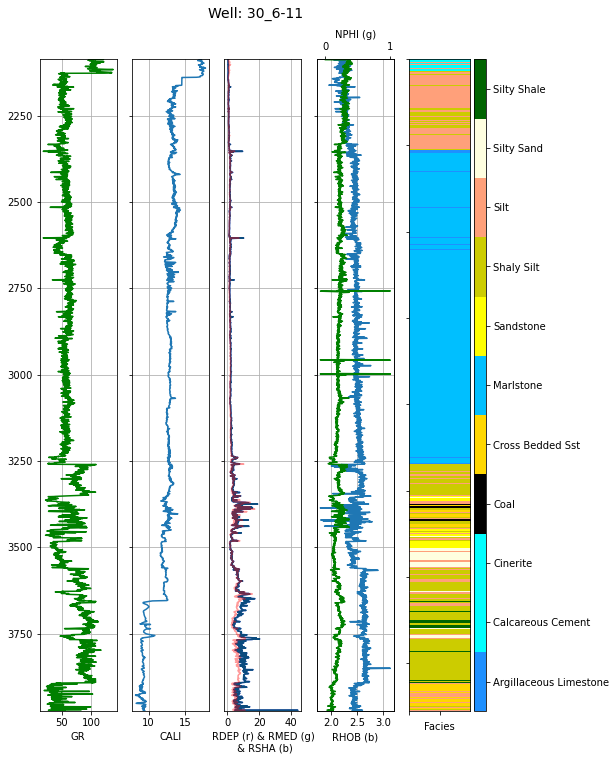

In [4]:
# View our well
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
plot_well("30_6-11", geolink, facies=geolink['LITHOLOGY_GEOLINK'].astype('category').values)

In [59]:
# we only take the data from CALI  onward for X. (Except DEPTH, to avoid biasing the model with depth)
X = geolink.iloc[:, 1:-1]
# LITHOLOGY_GEOLINK will be our class y.
y = geolink["LITHOLOGY_GEOLINK"]
X

,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED
DEPT,,,,,,,,,,
2085.750000,17.159000,0.072,0.00000,2.220757,109.011002,127.011429,1.170,42.013000,0.547,0.547
2085.875000,17.187000,0.014,0.00000,2.163988,113.018997,127.219872,1.147,41.969002,0.549,0.549
2086.000000,17.198000,0.000,0.00000,2.132627,115.380997,127.867149,1.131,42.324001,0.550,0.550
2086.125000,17.193001,0.032,0.00000,2.138454,116.207001,128.846787,1.125,42.834999,0.545,0.545
2086.250000,17.179001,0.074,0.00000,2.170922,116.153000,130.015976,1.130,43.605999,0.535,0.535
...,...,...,...,...,...,...,...,...,...,...
3974.250732,9.486000,0.044,0.11920,2.486290,54.765999,64.817436,3.815,38.742001,5.172,5.172
3974.375488,9.487000,0.035,0.11586,2.472456,52.576000,63.746723,3.773,39.074001,5.172,5.172
3974.500488,9.491000,0.025,0.11379,2.455452,49.529999,63.055447,3.729,38.865002,5.157,5.157


NOTE: our dataset is imbalanced, this is always important when considering a problem. it has two implications:
    
1. Our baseline accuracy is 46.5. We can get this by always guessing the most common class
2. if we get poor performance may want to consider techniques to deal with unbalanced data. However we do not need to do this in this notebook
3. We also mostly care about standstone which is a common drilling target

In [60]:
def train_test_split(*arrays, test_size=0.2):
    """Split by depth"""
    results = []
    i_split = int(len(arrays[0])*(1-test_size))
    for d in arrays:
        if isinstance(d, (pd.DataFrame, pd.Series)):
            train = d.iloc[:i_split]
            test = d.iloc[i_split:]
        else:
            train = d[:i_split]
            test = d[i_split:]
        results.append(train)
        results.append(test)
    return results
    

## Data Split

In [61]:
# Note that, on this data, it might be better to split by depth. 
# But we will keep it simple and standard to introduct the topic of test, train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12090, 10), (3023, 10), (12090,), (3023,))

(<Figure size 576x864 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb9ab2d588>,
       dtype=object))

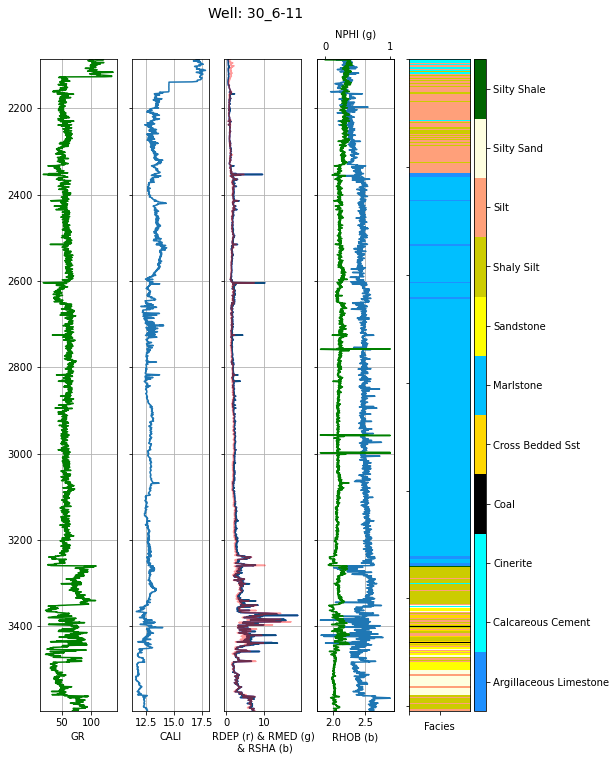

In [65]:
# View our well
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
plot_well("30_6-11", X_train.reset_index(), facies=y_train.astype('category').values)

(<Figure size 576x864 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb9a90e860>,
       dtype=object))

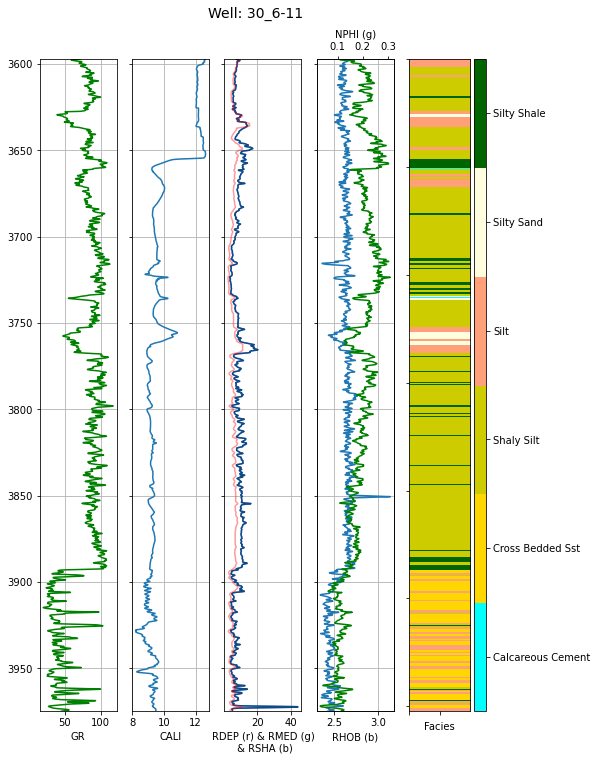

In [67]:
# View our well test
plot_well("30_6-11", X_test.reset_index(), facies=y_test.astype('category').values)

Shaly Silt           0.614290
Silt                 0.149190
Cross Bedded Sst     0.132319
Silty Shale          0.074760
Silty Sand           0.026133
Calcareous Cement    0.003308
Name: LITHOLOGY_GEOLINK, dtype: float64

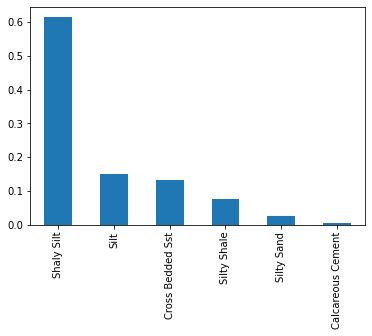

In [9]:
# Check dataset label balance
counts = y_test.value_counts()
counts = counts[counts>0]/counts.sum()
counts.plot.bar()
counts

## 3. K-Nearest Neighbors (KNN) <a name="knn"></a>
**Example of decision boundaries using KNN:**
<br/>
<div>
    Original Dataset. The dataset which consists of three classes (red,green and blue points). (For KNN classification example.)
<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Data3classes.png" width=300 height=300/>
    Decision Boundaries using 1NN algorithm
<img src="https://upload.wikimedia.org/wikipedia/commons/5/52/Map1NN.png" width=300 height=300/>
</div>

Images sources: [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#/media/File:Data3classes.png)
 distributed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license.
          
The code presented in this section is inspired from the official documentation [here](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py).

According to Wikipedia:
>k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation. Since this algorithm relies on distance for classification, normalizing the training data can improve its accuracy dramatically.

In [10]:
# Get types of Lithology
classes = list(geolink["LITHOLOGY_GEOLINK"].unique())
print("Classes: {}".format(classes))
print("Total Classes: {}".format(len(classes)))

Classes: ['Cinerite', 'Silt', 'Shaly Silt', 'Calcareous Cement', 'Argillaceous Limestone', 'Marlstone', 'Silty Shale', 'Silty Sand', 'Sandstone', 'Cross Bedded Sst', 'Coal']
Total Classes: 11


In [11]:
# Let's check the classes
y_train.to_numpy()

array(['Cinerite', 'Silt', 'Silt', ..., 'Shaly Silt', 'Shaly Silt',
       'Shaly Silt'], dtype=object)

There a total of 11 classes. However, like in the majority of machine learning algorithms, it is recommended to encode target values.


There are different encoder preprocessing functions available in the scikit learn library. For this example we will use the [<code>LabelEncoder</code>](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html):

> Encode target labels with a value between 0 and n_classes-1. This transformer should be used to encode target values, i.e. y, and not the input X.

In [12]:
# Label Encoder
le = preprocessing.LabelEncoder()
# This will help the LabelEncoder to map the classes to a corresponding value between 0 and n_classes-1
le.fit(classes)

LabelEncoder()

In [13]:
# We can look at the labels in this object
le.classes_

array(['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal',
       'Cross Bedded Sst', 'Marlstone', 'Sandstone', 'Shaly Silt', 'Silt',
       'Silty Sand', 'Silty Shale'], dtype='<U22')

The number of `neighbors` is a hyperparameter that must be set for this algorithm. We will arbitrarily select a value of 15 for this hyperparameter.

> In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)#:~:text=In%20machine%20learning%2C%20a%20hyperparameter,weights%20are%20derived%20via%20training.)

In [14]:
# Number of Neighbors around our datapoint to be classified
knn_classifier = KNeighborsClassifier(n_neighbors = 15)
# Now we will use the y values and transform the labels.
transformed_y_train = le.transform(y_train.to_numpy())
print('Transformed labels:',transformed_y_train)
# Let's fit the data
knn_classifier.fit(X_train, transformed_y_train)

Transformed labels: [2 8 8 ... 7 7 7]


KNeighborsClassifier(n_neighbors=15)

In [15]:
# Evaluation Time
y_pred = knn_classifier.predict(X_test)
y_true = le.transform(y_test.to_numpy())
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6619252398279855


We were able to predict the 11 different classes with >90% accuracy using new data. This is slightly better than the baseline, however the accuracy can be improved. Let's train using the same algorithm and hyperparameters but this time we will normalise the data.

## Normalised Data

There are options to normalising the data, which fit the petrophysics data better, but here will just consider normalising over the whole well.


### Why normalise the data?

Many machine learning (ML) algorithms attempt to find trends in the data by comparing the features of data points. However, machine learning algorithms usually struggle more in the training phase when the features are on different scales. Normalise the data will almost always improve the results for ML algorithms.

There are different ways to normalised the data and usually, each method has pros and cons. For example, some methods are better at dealing with outliers than others.

Two of the most popular methods for normalising the data are:

* Standard Score:
$\frac {X-\mu }{\sigma }$

* Min-Max Feature Scaling:
$X'={\frac {X-X_{\min }}{X_{\max }-X_{\min }}}$

More information about normalisation [here](https://en.wikipedia.org/wiki/Normalization_(statistics))

In [16]:
# Let's use Standard Score for this example
normalized_df = (X - X.mean()) / X.std()

In [17]:
# These are the original max values of the dataset
X.max()

CALI     17.809999
DRHO      3.687000
NPHI      1.000000
RHOB      3.137856
GR      137.761002
DTC     150.588577
RDEP     17.223000
SP       78.280998
RSHA     44.223000
RMED     44.223000
dtype: float64

In [18]:
# These are the original max values after normalising
normalized_df.max()

CALI     3.298296
DRHO    27.904426
NPHI    12.582814
RHOB     5.026973
GR       4.192968
DTC      2.961754
RDEP     6.493673
SP       7.234913
RSHA    12.750651
RMED    12.750651
dtype: float64

In [19]:
# Let's used the normalized data for both for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    normalized_df, y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12090, 10), (3023, 10), (12090,), (3023,))

In [20]:
# Label Encoder
le = preprocessing.LabelEncoder()
# This will help the LabelEncoder to map the classes to a corresponding value between 0 and n_classes-1
le.fit(y.to_numpy())

# Now we will use the y values and transform the labels.
transformed_y_train = le.transform(y_train)

In [21]:
# Normalized knn
knn_classifier_norm = KNeighborsClassifier(n_neighbors=15)
# Let's fit the data
knn_classifier_norm.fit(X_train, transformed_y_train)
# Evaluation Time
y_pred = knn_classifier_norm.predict(X_test)
y_true = le.transform(y_test)
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.5613628845517697


So now we got an accuracy of >91%. Normalising will usually help in the training process. So it's a good practice to preprocess the data before the training phase. However, some machine learning algorithms such as KNN are robust enough to work well with different scales so normalization might not be necessary in some cases. 

#### So... What if we change the hyperparameters of a classifier such as the number of `neighbors`?

We can see in the examples below how changing <code>n_neighbors</code> affect the performance of the final model.

The accuracy for the same normalised model are:

- n_neighbors = 10, accuracy: 93%
- n_neighbors = 5,  accuracy: 94%
- n_neighbors = 1,  accuracy: 96%
We could  manually try different values until we find the best hyperparameters. Of course, this approach could be very time consuming, in particular, when we have a big feature space and want to optimise many hyperparameters. One way to solve this problem is automating the search of hyperparameters. This is also called Hyperparameter Optimisation. We will get deeper into this concept in the next sessions.

In [22]:
# Normalized knn
knn_classifier_knn10 = KNeighborsClassifier(n_neighbors=10)
# Let's fit the data
knn_classifier_knn10.fit(X_train, transformed_y_train)
# Evaluation Time
y_pred = knn_classifier_knn10.predict(X_test)
y_true = le.transform(y_test)
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.5309295401918623


In [23]:
# Normalized knn 5
knn_classifier_knn5 = KNeighborsClassifier(n_neighbors=5)
# Let's fit the data
knn_classifier_knn5.fit(X_train, transformed_y_train)
# Evaluation Time
y_pred = knn_classifier_knn5.predict(X_test)
y_true = le.transform(y_test)
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.5385378762818392


In [24]:
# Normalized knn
knn_classifier_knn1 = KNeighborsClassifier(n_neighbors=1)
# Let's fit the data
knn_classifier_knn1.fit(X_train, transformed_y_train)
# Evaluation Time
y_pred = knn_classifier_knn1.predict(X_test)
y_true = le.transform(y_test)
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.444260668210387


<div class="alert alert-success">
  <h2>Exercise 1</h2>

  Let's practice some of the key concepts we have learned so far. 
    
  0. Choose the data for well log '30_6-14'. 
  1. Normalised and split the dataset provided (Use 85\% of the data for training and 15\% for testing)
  2. Transform the data using label encoding (This is done automatically by scikit-learn for some ML methods. However, it is good to get used to this concept).
  3. Train a KNN model using <code>n_neighbors</code>= 1,5,10,15
  4. Compare the accuracy of the different models

  <details>
  <summary><b>→ Hints</b></summary>
   - In this notebook we have already covered all the steps necessary to complete this exercise. You need to load again the dataset but selecting this time the well log '30_6-14'. Copy and paste the code and modify it as needed.
      
  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>
    
  ```python
    # View our well, it's similar to the last one
    from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
    plot_well("30_6-14", geolink, facies=geolink['LITHOLOGY_GEOLINK'].astype('category').values)
    # Exercise

    # Write your code below:

    # 0. Select a different well
    interim_locations = Path("../../data/processed/geolink_norge_dataset/")
    # Load processed dataset
    geolink_all = pd.read_parquet(
       interim_locations / "geolink_norge_well_logs_train.parquet"
    ).set_index(["Well", "DEPT"])
    # Add Depth as column
    geolink_all['DEPT'] = geolink_all.index.get_level_values(1)
    # Work with one well
    geolink = geolink_all.xs('30_6-14')

    # 1. Normalise dataset and Split well log dataset here

    # We only take the data from CALI  onward for X.
    X = geolink.iloc[:, 1:-1]
    # LITHOLOGY_GEOLINK will be our class y.
    y = geolink["LITHOLOGY_GEOLINK"]
    # Normalize data
    normalized_X = (X - X.mean()) / X.std()

    # Let's used the normalized data for both for training and testing
    X_train, X_test, y_train, y_test = train_test_split(
       normalized_X, y.to_numpy(), test_size=0.15, random_state=1
    )

    # 2. Transform the data using label encoding

    # Label Encoder
    le = preprocessing.LabelEncoder()
    classes = list(geolink["LITHOLOGY_GEOLINK"].unique())
    # This will help the LabelEncoder to map the classes to a corresponding value between 0 and n_classes-1
    le.fit(classes)
    # Now we will use the y values and transform the labels.
    transformed_y_train = le.transform(y_train)
    y_test_true = le.transform(y_test)
    # 3. Train your models 15NN

    # Note: In this example code we are just showing 15NN
    # Number of Neighbors around our datapoint to be classified

    # 1NN
    n_neighbors = 1
    cls_1nn = KNeighborsClassifier(n_neighbors)
    # Let's fit the data
    cls_1nn .fit(X_train, transformed_y_train)

    # 5NN
    n_neighbors = 5
    cls_5nn = KNeighborsClassifier(n_neighbors)
    # Let's fit the data
    cls_5nn.fit(X_train, transformed_y_train)

    # 10NN
    n_neighbors = 10
    cls_10nn = KNeighborsClassifier(n_neighbors)
    # Let's fit the data
    cls_10nn.fit(X_train, transformed_y_train)

    # 15NN
    n_neighbors = 15
    cls_15nn = KNeighborsClassifier(n_neighbors)
    # Let's fit the data
    cls_15nn.fit(X_train, transformed_y_train)

    # 4. Compare the accuracy of your models

    # Evaluation Time
    y_pred = cls_1nn.predict(X_test)
    print("Accuracy 1NN: {}".format(accuracy_score(y_test_true, y_pred)))

    # Evaluation Time
    y_pred = cls_5nn.predict(X_test)
    print("Accuracy 5NN: {}".format(accuracy_score(y_test_true, y_pred)))

    # Evaluation Time
    y_pred = cls_10nn.predict(X_test)
    print("Accuracy 10NN: {}".format(accuracy_score(y_test_true, y_pred)))

    # Evaluation Time
    y_pred = cls_15nn.predict(X_test)
    print("Accuracy 15NN: {}".format(accuracy_score(y_test_true, y_pred)))  
  ```

  </details>

  </div>


In [25]:
# Exercise

# Write your code below:

# 0. Select a different well

# 1. Normalise dataset and Split well log dataset here

# 2. Transform the data using label encoding

# 3. Train your models 1NN, 5NN, 10NN, 15NN

# 4. Compare the accuracy of your models

# 4. Support Vector Machines (SVM) <a name="svm"></a>

**A bit of history:**

> The Support Vector Machine (SVM) algorithm is a popular machine learning tool that offers solutions for both classification and regression problems. Developed at AT&T Bell Laboratories by Vapnik with colleagues (Boser et al., 1992, Guyon et al., 1993, Vapnik et al., 1997), it presents one of the most robust prediction methods, based on the statistical learning framework.

**How does it works?**
> An SVM performs classification tasks by constructing hyperplanes in a multidimensional space that separates cases of different class labels. You can use an SVM when your data has exactly two classes, e.g. binary classification problems


The graphic below shows how a support vector machine would choose a separating hyperplane for two classes of points in 2D. H1 does not separate the classes. H2 does, but only with a small margin. H3 separates them with the maximum margin.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/1024px-Svm_separating_hyperplanes_%28SVG%29.svg.png" width=300 height=300/>

[Source Image](https://en.wikipedia.org/wiki/Support_vector_machine#/media/File:Svm_separating_hyperplanes_(SVG).svg)

One of the limitations of SVMs is that they inherently do binary classification. However, there are different methods to extend SVMs and use them in multiclass problems. The most common methods involve transforming the problem into a set of binary classification problems, by one of two strategies:

- One vs. the rest. For 𝑘 classes, 𝑘 binary classifiers are trained. Each determines whether an example belongs to its 'own' class versus any other class. The classifier with the largest output is taken to be the class of the example.
- One vs. one. A binary classifier is trained for each pair of classes. A voting procedure is used to combine the outputs.

Sources: [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine), [SVMs](https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html), [Multiclass SVM](https://stats.stackexchange.com/questions/215342/can-a-linear-svm-only-have-2-classes)


**Scikit-learn Implementation:**

Multiclass and Multilabel algorithms:

> **Warning:** All classifiers in scikit-learn do multiclass classification out-of-the-box. You don’t need to use the sklearn.multiclass module unless you want to experiment with different multiclass strategies.

More information about Multiclass classification in scikit-learn [here](https://scikit-learn.org/stable/modules/multiclass.html)

The SVC implementation is not efficient for large datasets. Instead we will use the LinearSVC implementation. Find more information in the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

> The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and might be impractical beyond tens of thousands of samples. For large datasets consider using sklearn.svm.LinearSVC or sklearn.linear_model.SGDClassifier instead, possibly after a sklearn.kernel_approximation.Nystroem transformer.

Sometimes, we will want to train and test our algorithm in a sample fo the data instead of the completed dataset. Some ML methods do not deal well with large datasets so taking a sample from the dataset would be preferable.


In [26]:
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
# Load processed dataset
geolink_all = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
# Add Depth as column
geolink_all['DEPT'] = geolink_all.index.get_level_values(1)

# Work with one well
geolink = geolink_all.xs("30_6-11")

In [27]:
print("Total rows in Geolink dataset for the selected well:", len(geolink))

Total rows in Geolink dataset for the selected well: 15113


Some algorithms will take significantly more time to train than others. In the case of SVMs the process of training can get slower as the number of data points is increased.

Note: For the example below, we will sample the data to get only 10,000 data points from the original geolink dataset instead of 22,921. This reduction in datapoints may affect the accuracy of the model. But it will be done for demonstration purposes.

In [53]:
# In our case, we will take a sample of 10,000 data points from one well
sample_dataset = geolink.sample(n=10000, replace=False, random_state=2020)

X_sample = sample_dataset.iloc[:, 1:-1]
y_sample = sample_dataset["LITHOLOGY_GEOLINK"]
# Normalise data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sample
)

clf = LinearSVC(
    penalty="l2",
    loss="squared_hinge",
    dual=True,
    tol=0.0001,
    C=100,
    multi_class="ovr",
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    verbose=0,
    random_state=2020,
    max_iter=10000,
)
clf.fit(X_train, y_train)

categories = y_sample.unique()
# Evaluation Time
y_pred = clf.predict(X_test)
y_pred = pd.Categorical(y_pred, categories=categories)
y_true = y_test
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.7685


In [54]:
print(sklearn.metrics.classification_report(y_true, y_pred))

                        precision    recall  f1-score   support

Argillaceous Limestone       0.62      0.21      0.31        39
     Calcareous Cement       0.00      0.00      0.00         3
              Cinerite       0.63      0.57      0.60        21
                  Coal       0.00      0.00      0.00         5
      Cross Bedded Sst       0.66      0.73      0.69        77
             Marlstone       0.86      0.98      0.92       920
             Sandstone       0.70      0.73      0.72        45
            Shaly Silt       0.74      0.76      0.75       438
                  Silt       0.55      0.45      0.50       340
            Silty Sand       0.64      0.46      0.54        78
           Silty Shale       0.00      0.00      0.00        34

              accuracy                           0.77      2000
             macro avg       0.49      0.45      0.46      2000
          weighted avg       0.74      0.77      0.75      2000



[]

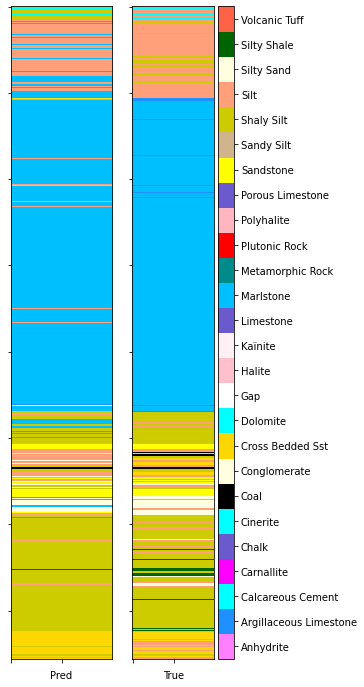

In [55]:
# Plot the results as well logs

# WARNING: we are NOT seperating test and train here. So we are displaying the whole well, which includes both
# See the RNN-Depth notebooks for a more detailed treatment, with better test train split
X_sample = geolink.iloc[:, 1:-1]
y_true = geolink["LITHOLOGY_GEOLINK"]
X_scaled = scaler.fit_transform(X_sample)
y_pred = clf.predict(X_scaled)

true = pd.Categorical(y_true)
pred = pd.Categorical(y_pred, categories=true.categories)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 12))
plot_facies(pred, ax=ax[0], colorbar=False, xlabel='Pred')
plot_facies(true, ax=ax[1], xlabel='True')
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
# TODO add bars

The results could be better with a deeper network and more data. We will revit this again in the Recurrent Neural Networks notebook.

We could also:
- give it a sequence of a logs, so it can see the context up an down the well
- give it the X and Y location of the well
- look at more logs, while using the GPU
- provide some human examples for each well
- project a geological model or geological maps onto the wells

# 5. Decision Trees <a name="decision-trees"></a>


> A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. 
Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Some **advantages** of using decision trees are:

- Simple to understand and interpret: People can understand decision tree models after a brief explanation. Trees can also be displayed graphically in a way that is easy for non-experts to interpret.

- Able to handle both numerical and categorical data. [1]

- Requires little data preparation: Other techniques often require data normalization. Since trees can handle qualitative predictors, there is no need to create dummy variables. [1]

- Performs well with large datasets. Large amounts of data can be analyzed using standard computing resources in a reasonable time.

**Limitations:** 
- Trees can be very non-robust. A small change in the training data can result in a large change in the tree and consequently the final predictions. [1]
- Decision-tree learners can create over-complex trees that do not generalize well from the training data.


Source: [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)

Source: [1] Gareth, James; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert (2015). An Introduction to Statistical Learning. New York: Springer. pp. 315. ISBN 978-1-4614-7137-0.

**Note:** Decision trees can be used for classification and regression.

In the first example, we will train a decision tree on the iris dataset.

We can use the function <code>plot_tree</code> to show the flowchart of the trained model. Find more information about plotting the decision surface of a decision tree [here](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py). As can be seen in the next plot, the maximum [depth](http://typeocaml.com/2014/11/26/height-depth-and-level-of-a-tree/) of the tree is 5. Usually decision trees with more levels (deeper trees) will be able to discriminate better and take more finetuned decisions, however, deeper trees are also likely to [overfit](https://en.wikipedia.org/wiki/Overfitting) easily. 

<div class="alert alert-info" style="font-size:100%">

**NOTE:** <br>

Use the hyperparameters `max_depth` and `max_features` carefully. Incresing those parameters might increase the [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) of the model but it is also likely to overfit the models at some point.
    <br/>
Using the correct metrics of evaluation is key to correctly assess the model.

</div>

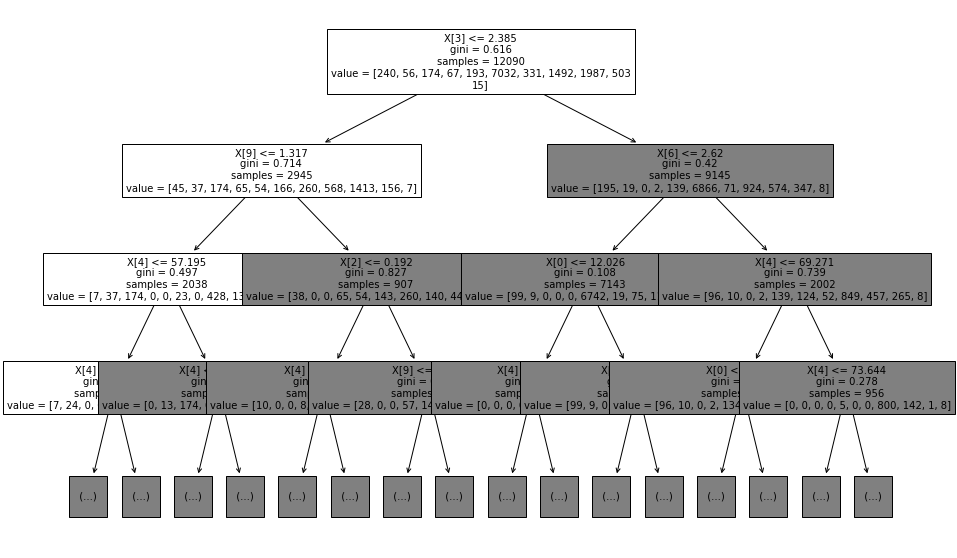

In [31]:
# Split dataset geolink. test_size =0.25
X_train, X_test, y_train, y_test = train_test_split(
    X, y
)

clf = tree.DecisionTreeClassifier(max_depth=4)
fig, ax = plt.subplots(figsize=(15, 10))
# X0 and y0 from iris_dataset
tree.plot_tree(clf.fit(X_train, y_train), max_depth=3, fontsize=10)
plt.show()

Now let's train a decision tree (DT) with our geolink dataset. For the next example, we will set the hyperparater max_depth to 100. Notice how the accuracy in the model changes. 

In [32]:
clf = tree.DecisionTreeClassifier(random_state=2020, max_depth=4)
clf = clf.fit(X_train, y_train)

# Evaluation Time
y_pred = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.642077406549785


We now have an accuracy of >92% just with the default hyperparameters. Let's train the DT again with a different hyperparameter.

In [33]:
clf2 = tree.DecisionTreeClassifier(random_state=2020, max_depth=20)
clf2 = clf2.fit(X_train, y_train)

# Evaluation Time
y_pred = clf2.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.32682765464770097


We got a greater accuracy just with the hyperparameter max_depth=20. Let's train the DT again with a different hyperparameter. In appearance, the first model would be better, however, there are other metrics besides accuracy that should be taken into account. There are also other methods to avoid overfitting. We will go deeper into this topic in the next sessions.

# 6. Random Forest <a name="random-forest"></a>

> A random forest is a meta estimator that fits several decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.


Random Forest is an ensemble method:
>The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm to improve generalizability/robustness over a single estimator.

We will learn more about ensemble methods in the next session.

Scikit-learn support Random Forest for classification and regression (<code>RandomForestClassifier</code> and <code>RandomForestRegressor</code>)

> In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details). 
The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yields decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice, the variance reduction is often significant hence yielding an overall better model.

This implementation of RandomForest only accepts numerical values. You should always encode categorical values.

Source: [Official Documentation Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

**Note:** The next 2 pieces of code might take several minutes to complete the training.

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.6821038703274892


Let's train again the model with different hyperparameters.

In [35]:
clf = RandomForestClassifier(max_depth=100, n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.6787958981144558


## References and further reading
The following sources have been used in the creation of this notebook:
- [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree)
- [SVMs](https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html)
- [Normalisation](https://en.wikipedia.org/wiki/Normalization_(statistics))
- [Seaborn Datasets](https://seaborn.pydata.org/generated/seaborn.load_dataset.html)
- [Scikit-learn Datasets](https://scikit-learn.org/stable/datasets/index.html)
